In [ ]:
using Pkg
Pkg.activate("..")

using Distributions, CairoMakie, LinearAlgebra, Symbolics, MiCRM, Random

# MiCRM system
In this notebook I will derive some quantities of interest when considering the effects of chemical perturbations on microbial communties.

## ODE System

We start with a slight modification of the MiCRM equations to include an external stressor $S$ with the sensitvtiy of each consumer poulation to the stressor given by $\gamma_i$

\begin{align}
    \frac{d C_i}{d t} &= C_i \left[\sum_\alpha u_{i \alpha} R_{\alpha}\left(1-\sum_{\beta}l_{\alpha \beta}\right) - m_i - \gamma_i S \right] \\
    \frac{d R_{\alpha}}{d t} &= \rho_{\alpha} - \omega_{\alpha} R_{\alpha} - \sum_i u_{i \alpha} C_i R_{\alpha} + \sum_{i \beta} u_{i \beta} C_i R_{\beta} l_{\beta \alpha} \\
    \frac{d S}{d t} &= -d S
\end{align}

# Press perturbations
I first will consider how the equiblirium state of the system changes with the introduction of this stressor, represented by the derivatives w.r.t. $S$:

\begin{align}
    \frac{dC^*_i}{dS} \quad \text{and} \quad \frac{dR^*_{\alpha}}{dS}
\end{align}

These quantities measure the change in the system with respect to a small constant (press) chemical perturbation.

## Matrix Representation
In order to calculate the sensitvties I first represent the system in matrix form (where the $^\mathbf{d}$ superscript indicates a diagnoal matrix of the appropriate size):

\begin{align}
    \frac{d\mathbf{C^*}}{dt} &= \mathbf{u} \mathbf{(1 - L 1)^d} \mathbf{R^*} - \mathbf{m} - S\mathbf{\gamma} \\
    \frac{d\mathbf{R^*}}{dt} &= \mathbf{\rho} - \mathbf{R^{*d}} \mathbf{\omega} - \mathbf{R^{*d} u' C^*} + \mathbf{L' R^{*d} u' C^*} \\
                           &= \mathbf{\rho} - \mathbf{R^{*d}} \mathbf{\omega} + \mathbf{(L' - I) R^{*d} u' C^*}\\
\end{align}

### Consumer derivative
Then taking the derivative of the consumer equation we get the resource sensitvity:
\begin{align}
    \gamma &= \mathbf{u (1 - L1)^d} \frac{d \mathbf{R^*}}{dS} \\
    \frac{d \mathbf{R^*}}{dS} &= (\mathbf{u (1 - L1)^d})^{-1} \gamma
\end{align}

Assuming all resources have the same leakage $\lambda$ (i.e. all metabolism is equally efficent)

\begin{align}
    \frac{d \mathbf{R^*}}{dS} &= (\mathbf{u} (1 - \lambda))^{-1} \gamma
\end{align}

### Resource derivative

And the consumer sensitivity from the resource equation:
\begin{align}
    \frac{d \mathbf{R^{*d}}}{dS} \omega &= \mathbf{(L' - I)} 
    \left( \frac{d \mathbf{R^{*d}}}{dS}  \mathbf{u' C^*} + \mathbf{R^{*d}} u' \frac{d\mathbf{C^*}}{dS} \right) \\
    \frac{d\mathbf{C^*}}{dS} &= \left[ \mathbf{(L' - I) R^{*d} u' }
    \right]^{-1}
    \left[ 
    \frac{d \mathbf{R^{*d}}}{dS} \omega - \mathbf{(L' - I)} \frac{d \mathbf{R^{*d}}}{dS}  \mathbf{u' C^*} 
    \right] \\
    &= \left[ \mathbf{(L' - I) R^{*d} u' }
    \right]^{-1}
    \left[ 
    (\mathbf{u (1 - L1)^d})^{-1} \gamma \omega - \mathbf{(L' - I)} (\mathbf{u (1 - L1)^d})^{-1} \gamma  \mathbf{u' C^*} 
    \right]
\end{align}

Note that the derivatives depend on botht the resource and consumer abundances at equilibrium

## Simulations

we can test these quantities with some simulations. The idea here is to take a system with no stressors at equilibrium. We then introduce a small quantitiy of the stressor in the environment which affects consumers via the additional mortaility term. We can then compare the predicted change in equilibirum abundance to the channge observed in the simulations. 

In [32]:
#generate system with 'random' parameters
#define functions to calculate sensitvtiy
function dRdS(p,C_extant)   
    return(pinv(p.u[C_extant,:] * diagm((ones(p.M) - p.l * ones(p.M)))) * p.γ[C_extant])
end

function dCdS(p, C_extant, R, C, dR)
   leakage_factor = (p.l' - I(p.M))
       
    a = pinv(leakage_factor * diagm(R) * p.u[C_extant,:]')
    b = diagm(dR) * p.ω - leakage_factor * diagm(dR) * p.u[C_extant,:]' * C[C_extant]

    return(a * b)
end

function calc_sensitvtiy(sol)
    #get final deriv + assert equilibrium
    print(minimum( sol(sol.t[end],Val{1})) )
    
    #get end masses
    C,R = sol[end][1:sol.prob.p.N], sol[end][sol.prob.p.N + 1  : end - 1]
    
    C_extant = findall(C .> eps())
    
    dR = dRdS(sol.prob.p, C_extant)
    dC = dCdS(sol.prob.p, C_extant, R, C, dR)
    
    return(vcat(dC[:],dR[:]))
end

calc_sensitvtiy (generic function with 1 method)

In [51]:
#solve system with stressor
#derivatives
function growth_MiCRM_stressor!(dx,x,p,t,i)
    dx[i] += -x[i] * p.m[i] - (x[i] * x[p.S_ind] * p.γ[i])
    for α = 1:p.M
        dx[i] += x[i] * x[α + p.N] * p.u[i,α] #uptake
        for β = 1:p.M
            dx[i] += -x[i] * x[α + p.N] * p.u[i,α] * p.l[α,β] #leakage
        end
    end
end

function stressor!(dx,x,p,t)
    dx[p.S_ind] = p.d * x[p.S_ind]
end

#derivative function
dx!(dx,x,p,t) = MiCRM.Simulations.dx!(dx,x,p,t;  growth! = growth_MiCRM_stressor!, extrinsic! = stressor!)


dx! (generic function with 1 method)

In [52]:
#function to generate parameters
function stressor_params(N, M, leakage, d) where {A <: Integer, B <: Integer, C <: AbstractFloat}
    @assert 0 <= leakage <= 1

    #uptake
    du = Distributions.Dirichlet(M,1.0)
    u = copy(rand(du, N)')

    #cost term
    m = ones(N)

    #inflow + outflow
    ρ,ω = ones(M),ones(M)
    ρ .+= M

    #leakage
    l = copy(rand(du,M)' .* leakage)
    
    #stressors
    γ = rand(N)
    S_ind = N+M+1
    
    d = 0.0
    
    return (N = N, M = M, u = u, m = m, ρ = ρ, ω = ω, l = l, λ = leakage, γ = γ, S_ind = S_ind, d = d)
end

stressor_params (generic function with 1 method)

  0.367561 seconds (1.03 k allocations: 639.594 KiB)


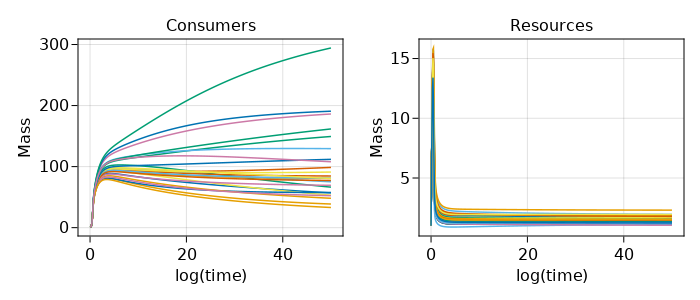

In [94]:
Random.seed!(42)

N,M = 25,50

fu(d) = MiCRM.Parameters.default_u_func(d, 100)

p = stressor_params(N,M,0.3)

u0 = ones(N+M+1)
u0[end] = 0.0

#tspan 
tspan = (0,1e4)

#setup prob
prob = ODEProblem(dx!,u0, tspan, p)
@time sol = solve(prob, AutoTsit5(Rosenbrock23()))

f = Figure(resolution = (700,300))
ax1 = Axis(f[1,1], xlabel = "log(time)", ylabel = "Mass", title = "Consumers")
ax2 = Axis(f[1,2], xlabel = "log(time)", ylabel = "Mass", title = "Resources")

log_safe(x) = log(max(1e-9, x))

t_plt = 0.0:0.1:50.0
sol_t = hcat(sol.(t_plt)...)

[lines!(ax1, t_plt, sol_t[i,:]) for i = 1:(N)]
[lines!(ax2, (t_plt), (sol_t[i,:])) for i = N+1:(N+M)]

f

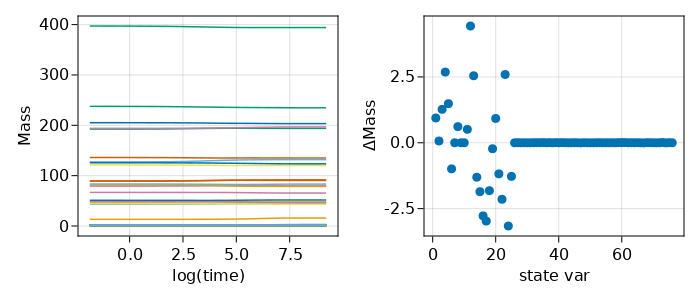

In [95]:
#introduce small-decaying stressor perturbation
u1 = sol[end]
u1[p.S_ind] = 1e-3

#simulate
prob = ODEProblem(dx!,u1, tspan, p)
sol1 = solve(prob, AutoTsit5(Rosenbrock23()))

f = Figure(resolution = (700,300))
ax = Axis(f[1,1], xlabel = "log(time)", ylabel = "Mass")

# lines!(ax, log.(sol1.t), sum(sol1[1:N,:],dims=1)[:])

[lines!(ax, log.(sol1.t), sol1[i,:]) for i = 1:(N+M)]

ay = Axis(f[1,2], xlabel = "state var", ylabel = "ΔMass")

scatter!(ay,  sol1[end] .- sol[end])

f

In [96]:
ext_1 = findall(sol[end][1:sol.prob.p.N] .< eps())
ext_2 = findall(sol1[end][1:sol.prob.p.N] .< eps())
setdiff(ext_2, ext_1)

Int64[]

-9.310545234488458e-7

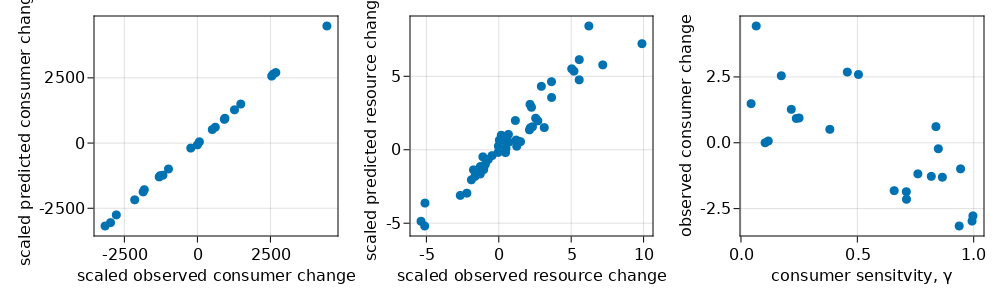

In [97]:
dS = calc_sensitvtiy(sol)

C_extinct = findall(sol[end] .< eps())

sol_ind = collect(1 : N+M)
deleteat!(sol_ind, C_extinct)

obs_change = (sol1[end][sol_ind] .- sol[end][sol_ind]) ./ u1[p.S_ind]

C_ind = 1: length(dS) - p.M
R_ind = length(dS) - p.M + 1 : length(dS)

f = Figure(resolution = (1000,300))
ax1 = Axis(f[1,1], xlabel = "scaled observed consumer change", ylabel = "scaled predicted consumer change")
scatter!(ax1, obs_change[C_ind], dS[C_ind])

ax2 = Axis(f[1,2], xlabel = "scaled observed resource change", ylabel = "scaled predicted resource change")
scatter!(ax2, obs_change[R_ind], dS[R_ind])

γ_vec = deepcopy(sol.prob.p.γ)
deleteat!(γ_vec, C_extinct)

ax3 = Axis(f[1,3], xlabel = "consumer sensitvity, γ", ylabel = "observed consumer change")
scatter!(ax3, γ_vec, obs_change[C_ind] .* u1[p.S_ind])

f

We can see here that thre predictions and observations have very good corespondance. On the rightmost plot we can also see that the degree to which consumers are negatively affected is correlated negatively with their sensitvtiy $\gamma$.  This relationship is linear, perhaps we can determine the factors that affect the slope of the line?

In [2]:
#for consumer 1
γ_pred = [sum((1 - 0.5) * p.u[i,:] .* dS[R_ind]) for i = 1:p.N]
deleteat!(γ_pred, C_extinct)

cor(γ_pred,γ_vec)


LoadError: UndefVarError: p not defined

In [3]:
a = 1
C_ind = collect(1:sol.prob.p.N)
deleteat!(C_ind, C_extinct)

[dS[R_ind][a] * sum(sol.prob.p.u[C_ind,a]) for a = 1:M] |> x -> x * 0.5 |> sum

LoadError: UndefVarError: sol not defined

In [100]:
sum(sol.prob.p.u[C_ind,4])

0.5647494286260203

In [101]:
(mean(γ_vec) * M) / 0.5

54.9124611171341

In [102]:
R = sol1[end][p.N+1 : end-1]

[0.5 * sum(p.u[i, :] .* R ) - p.m[i] - p.γ[i]*1e-2 for i = 1:N] |> sum

-7.271793345484942

In [103]:
p.N * mean(p.u)  *  (1 - 0.5) * [R[a] for a = 1:M] |> sum

18.381795652820898

In [104]:
(p.m .- p.γ[i]*1e-2 |> sum) / (p.N * mean(p.u)  *  (1 - 0.5) |> sum)

LoadError: UndefVarError: i not defined

In [188]:
    [cor(p.u[i,:],R) for i = 1:N]

25-element Vector{Float64}:
 -0.16466220678256474
 -0.1693210885212514
 -0.10842501654630042
 -0.17658127076875307
 -0.2340860917903804
 -0.15591783647346535
 -0.16941666299245148
 -0.23216255074046663
 -0.11217912960965315
 -0.15595731003409047
 -0.1830509472641463
 -0.20713872508248707
 -0.1618616668093763
 -0.20732170581477158
 -0.20636202056480915
 -0.14111611471597685
 -0.16100665643032916
 -0.16926530225770173
 -0.17008252526282244
 -0.19713343419311502
 -0.14237095177700895
 -0.17611915421624139
 -0.1142872595976885
 -0.1043767400355604
 -0.18108888590379366

In [198]:
[sum(p.u[i,:] .* R) for i = 1:N] |> sum

50.060166331242456

In [214]:
[sum(mean(p.u) * p.N) * R[a] for a = 1:M] |> sum

51.48321479926973

In [213]:
mean(p.u) * p.N

0.5

# Linear Approximation
Whilst the expressions above give the longterm response of a community to the presence of a stressor we might also be interested in short-term transitory responses. To characterise these responses it would be useful to know characteristics such as:
* what is the rate of recovery for a perturbation?
* what are the transient dynamics (e.g. initial amplification)

# Resiliance

One idea could be to characterise the return time of the system. This is given by the inverse of the dominant eigenvalue of the Jacobian matrix. The jacobian has the folowing block structure:
\begin{align}
\mathbf{J = 
\begin{bmatrix}
\frac{\delta^2 C}{\delta t C} & \frac{\delta^2 C}{\delta t R} & \frac{\delta^2 C}{\delta t S} \\
\frac{\delta^2 R}{\delta t C} & \frac{\delta^2 R}{\delta t R} & \frac{\delta^2 R}{\delta t S} \\
\frac{\delta^2 S}{\delta t C} & \frac{\delta^2 S}{\delta t R} & \frac{\delta^2 S}{\delta t S}
\end{bmatrix} = 
\begin{bmatrix}
\frac{\delta^2 C}{\delta t C}^d & \frac{\delta^2 C}{\delta t R} & \frac{\delta^2 C}{\delta t S} \\
\frac{\delta^2 R}{\delta t C} & \frac{\delta^2 R}{\delta t R} & 0 \\
0 & 0 & \frac{\delta^2 S}{\delta t S}
\end{bmatrix}}
\end{align}

where specifically the consumer derivatives form a diagonal matrix (as consumer biomasses are not directly dependent), resources do not depend on stressors and the stressor is only dependent on itself. 

In [234]:
#Function to calculate Jacobian from a given parameter set
# This shouls be arround 0!
function calc_jac(sol)
    p = sol.prob.p

    C = sol[end][1:p.N]
    R = sol[end][(p.N+1):(end- length(p.S_ind))]
    S = sol[end][p.S_ind]
    
    λ = p.l*ones(p.M)
    
    #
    J = zeros(p.N + p.M + 1, p.N + p.M + 1)
    
    for i = 1:p.N
        for j = 1:p.M
            if i == j
                J[i,j] = sum(p.u[i,:] .* R .* (1 .- λ)) - p.m[i] - p.γ[i] * S
            else
                J[i,j] = 0
            end
        end

        for β = 1:p.M
            J[i,p.N + β] = p.u[i,β] * C[i] * (1 - λ[β])
        end
        
        J[i, p.S_ind] = -C[i] * p.γ[i]
    end

    for α = 1:p.M
        for j = 1:p.N
            J[α + p.N, j] = -R[α] * p.u[j,α] + sum(R .* p.u[j,:] .* p.l[:,α])
        end

        for β = 1:p.M
            if α == β
                J[α+p.N,β+p.N] = -p.ω[β] - sum(p.u[:,β] .* C) + sum(p.u[:,β] .* C .* p.l[β,α])
            else
                J[α+p.N,β+p.N] = sum(p.u[:,β] .* C .* p.l[β,α])
            end
        end
    end
    
    J[p.S_ind,p.S_ind] = p.d
    
    return(J)
end

calc_jac (generic function with 1 method)

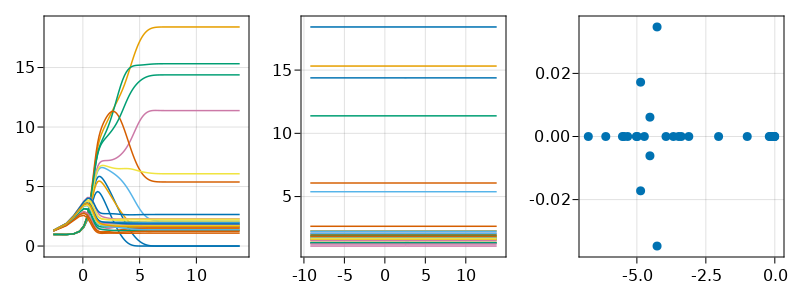

In [235]:
using Random

#generate community with stressor
function rand_stressor(N,M)
    p_dict = MiCRM.Parameters.random_micrm_params(N,M,0.4)
    
    p_dict[:γ] = rand(N)
    p_dict[:S_ind] = N+M+1
    p_dict[:d] = -0.2
    p_dict[:ρ] .+= sqrt(M)
    
    return(MiCRM.Simulations.dict_to_struct(p_dict, Symbol("param")))
end

#solve a system without the stressor
function sys_eq(p)
    u0 = ones(p.N+p.M+1)
    u0[p.S_ind] = 0.0

    #simulate
    prob = ODEProblem(dx!,u0, (0.0,1e6), p)
    sol1 = solve(prob, AutoTsit5(Rosenbrock23()))
    
    return(sol1)
end

#plot solution
function plot_sol!(sol, ax)
    [lines!(ax, log.(sol.t), sol[i,:]) for i = 1:(sol.prob.p.N+sol.prob.p.M)]
end

#remove extinct consumers from a solution object 
function remove_extinct(sol)
    p = sol.prob.p
    
    to_keep = findall(sol[end][1:p.N]  .> eps())
    to_rm = findall(sol[end][1:p.N]  .< eps())
    
      p_dict = MiCRM.Simulations.struct_to_dict(p)

    #remove from params
    p_dict[:u] = p_dict[:u][to_keep,:]
    p_dict[:m] = p_dict[:m][to_keep]
    p_dict[:γ] = p_dict[:γ][to_keep]
    p_dict[:N] = length(to_keep)
    p_dict[:S_ind] = p_dict[:N] + p_dict[:M] + 1

    p_struct = MiCRM.Simulations.dict_to_struct(p_dict,:param)

    u0 = sol(sol.t[end])
    deleteat!(u0, to_rm)
        
    #simulate
    prob = ODEProblem(dx!,u0, (0.0,1e6), p_struct)
    return(solve(prob, AutoTsit5(Rosenbrock23())))
end



param = rand_stressor(10,20)
sol = sys_eq(param)
sol_rm = remove_extinct(sol)

f = Figure(resolution = (800,300))

plot_sol!(sol, Axis(f[1,1]))
plot_sol!(sol_rm, Axis(f[1,2]))

J_sol = calc_jac(sol_rm)

λ = eigvals(J_sol)

scatter!(Axis(f[1,3]),(real(λ)),imag(λ))

f

In [236]:
λeff = (real(eigvals(J_sol)));

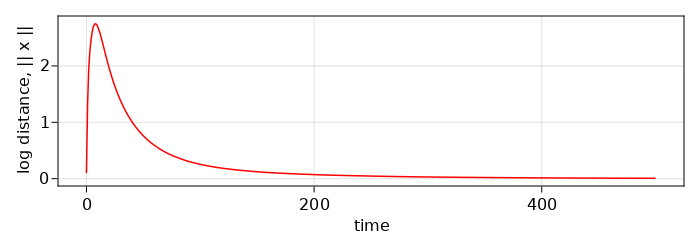

In [237]:
#perturbation via only the stressor
# Random.seed!()
function stressor_perterb(sol)
    #testing perterbations
    p = sol.prob.p
    u0 = deepcopy(sol[end])
    u0[p.S_ind] = 0.1
    # println(norm(sol[end] .- u0))

    prob = ODEProblem(dx!,u0, (0.0,1e6), p)
    return(solve(prob, AutoTsit5(Rosenbrock23())))
end

#perterbation via any statevariable the 
function rand_perterb(sol)
    #testing perterbations
    p = sol.prob.p
    u0 = deepcopy(sol[end])
    u0[1: end-1] .+= normalize(randn(length(u0)-1), 2) ./ 10
        # println(norm(sol[end] .- u0))


    prob = ODEProblem(dx!,u0, (0.0,1e6), p)
    return(solve(prob, AutoTsit5(Rosenbrock23())))
end

#get solution relative to equilibirum norm 
total_norm = (sol, t) -> norm(sol(t) .- sol[end])

s = stressor_perterb(sol_rm)
r = [rand_perterb(sol_rm) for i = 1:100]

t_vec = 0.0:1.0:5e2 #10 .^ (-1:0.1:3)

C_vec =  total_norm.(Ref(s), t_vec)
r_vecs = map(x -> total_norm.(Ref(x), t_vec), r)

f = Figure(resolution = (700,250))

ax1 = Axis(f[1,1], xlabel = "time", ylabel = "log distance, || x ||")
# [lines!(ax1,(t_vec), log.(i)  , color = ("black",0.1)) for i = r_vecs]
lines!(ax1, (t_vec), (C_vec), t_vec, color = "red")
# [lines!(ax1, t_vec, log.(C_vec)[1] .+ t_vec .* λeff[end - i]) for i = 0]

f


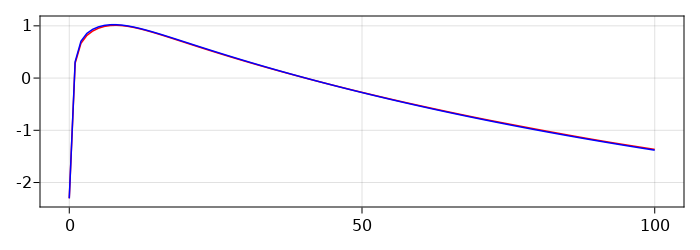

In [238]:
λ0 = 0.5(J_sol' + J_sol) |> eigen |> x -> x.values

t_vec = 0.0:1.0:100.0 #10 .^ (-1:0.1:3)

C_vec =  total_norm.(Ref(s), t_vec)
r_vecs = map(x -> total_norm.(Ref(x), t_vec), r)

#approx
u0 = zeros(length(s[end]))
u0[s.prob.p.S_ind] = 0.1
C = u0 * u0'

#get norm for specific perturbation
g(t) = tr(exp(J_sol*t) * C * exp(J_sol'*t)) |> sqrt
xnorm = g.(t_vec)

#get norm for median perterbation
C = 1/length(s[end]) * I(length(s[end])) ./ 10^2
C[end,end] = 0.0
h(t) = tr(exp(J_sol * t) * C * exp(J_sol' * t)) |> sqrt

ynorm = h.(t_vec)

# C = (u0 * u0')
# λ0_app = tr(C * J_sol) / tr(C)



f = Figure(resolution = (700,250))

ax1 = Axis(f[1,1])
# [lines!(ax1,(t_vec), log.(i)  , color = ("black",0.05)) for i = r_vecs]
lines!(ax1, (t_vec), log.(C_vec), t_vec, color = "red")
lines!(ax1, (t_vec), log.(xnorm), t_vec, color = "blue")

# lines!(ax1,t_vec,log.(ynorm),color = "green")



f


# Alternate model

\begin{align}
    \frac{d C_i}{d t} &= C_i \left[ \sum_\alpha f(S,\gamma_i) u_{i \alpha} R_{\alpha}\left(1-\sum_{\beta}l_{\alpha \beta}\right) - m_i \right] \\
    \frac{d R_{\alpha}}{d t} &= \rho_{\alpha} - \omega_{\alpha} R_{\alpha} - \sum_i f(S,\gamma_i) u_{i \alpha} C_i R_{\alpha} + \sum_{i \beta} f(S,\gamma_i) u_{i \beta} C_i R_{\beta} l_{\beta \alpha}
\end{align}

In [239]:
#solve system with stressor
#derivatives
f_sens(S,γ) = max(1 - γ*S, 0.0)

function growth_MiCRM_stressor_uptake!(dx,x,p,i,t)
    dx[i] = -x[i] * p.m[i]
    for α = 1:p.M
        dx[i] += x[i] * x[α + p.N] * p.u[i,α] * f_sens(x[p.S_ind],p.γ[i]) #uptake
        for β = 1:p.M
            dx[i] += -x[i] * x[α + p.N] * p.u[i,α] * f_sens(x[p.S_ind],p.γ[i]) * p.l[α,β] #leakage
        end
    end
end

function uptake_MiCRM_stressor!(dx,x,p,α,i,t)
    dx[α + p.N] += -x[α + p.N] * x[i] * p.u[i,α] * f_sens(x[p.S_ind],p.γ[i])
    for β = 1:p.M
        dx[α + p.N] += x[β + p.N] * x[i] * p.u[i,β] * p.l[β,α] * f_sens(x[p.S_ind],p.γ[i])
    end
end

function stressor!(dx,x,p,t)
    dx[p.S_ind] = p.d * x[p.S_ind]
end

#derivative function
dx_2!(dx,x,p,t) = MiCRM.Simulations.dx!(dx,x,p,t;  growth = growth_MiCRM_stressor_uptake!,
        extrinsic = stressor!,
        uptake = uptake_MiCRM_stressor!)


dx_2! (generic function with 1 method)

  1.779714 seconds (1.87 M allocations: 107.409 MiB, 83.98% compilation time)
  2.404014 seconds (2.01 M allocations: 114.277 MiB, 2.15% gc time, 69.45% compilation time)


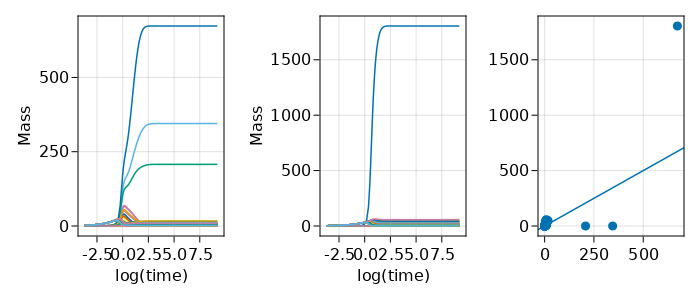

In [240]:
N,M = 25,50

fu(d) = MiCRM.Parameters.default_u_func(d, 100)

p_dict = MiCRM.Parameters.random_micrm_params(N,M,0.5)

p_dict[:γ] = rand(N)
p_dict[:S_ind] = N+M+1
p_dict[:d] = 0.0
p_dict[:ρ] .+= M

p = MiCRM.Simulations.dict_to_struct(p_dict,  :par)


u0 = ones(N+M+1)
u0[end] = 10.0
#tspan 
tspan = (0,1e4)
#setup prob
prob1 = ODEProblem(dx!,u0, tspan, p)
@time sol1 = solve(prob1, AutoTsit5(Rosenbrock23()))

#setup prob
prob2 = ODEProblem(dx_2!,u0, tspan, p)
@time sol2 = solve(prob2, AutoTsit5(Rosenbrock23()))

f = Figure(resolution = (700,300))
ax1 = Axis(f[1,1], xlabel = "log(time)", ylabel = "Mass")
ax2 = Axis(f[1,2], xlabel = "log(time)", ylabel = "Mass")
ax3 = Axis(f[1,3])

plot_sol!(sol1,ax1)
plot_sol!(sol2,ax2)
scatter!(ax3, sol1[end],sol2[end])
abline!(ax3, 0, 1)

f

In [219]:
#generate community with stressor
function rand_stressor(N,M, d)
    p_dict = MiCRM.Parameters.random_micrm_params(N,M,0.4)
    
    p_dict[:γ] = rand(N)
    p_dict[:S_ind] = N+M+1
    p_dict[:d] = d
    p_dict[:ρ] .+= sqrt(M)
    
    return(MiCRM.Simulations.dict_to_struct(p_dict, Symbol("param")))
end


#solve a system with the stressor1 and 2 and return total biomass of each 
function sys_eq_stress(p, S)
    u0 = ones(p.N+p.M+1)
    u0[p.S_ind] = S

    #simulate
    prob = ODEProblem(dx!,u0, (0.0,1e6), p)
    sol1 = solve(prob, AutoTsit5(Rosenbrock23()), dense = false, save_everystep = false)
    
    prob = ODEProblem(dx_2!,u0, (0.0,1e6), p)
    sol2 = solve(prob, AutoTsit5(Rosenbrock23()), dense = false, save_everystep = false)
    
    
    return(sum(sol1[end][1:p.N]), sum(sol2[end][1:p.N]))
end

sys_eq_total(p) = sum(sys_eq(p)[end][1 : p.N])

function sim(p, S)
    no_stress = sys_eq_total(p)
    return([i for i = (sys_eq_stress(p, S))])
    
end


sim (generic function with 3 methods)

In [220]:
N = 10
M = 5
res = zeros(2,N,M)

for j = 1:M
        p = rand_stressor(25,50, 0.0)
    for i = 1:N
        res[:,i,j] .= sim(p, range(0.0,1.0,length = N)[i])
    end
end

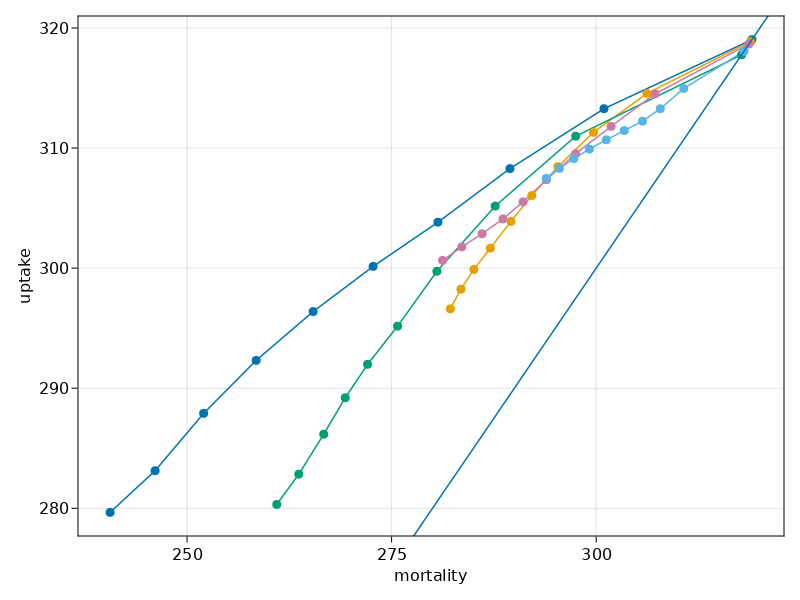

In [223]:
f = Figure()
ax = Axis(f[1,1], xlabel = "mortality", ylabel = "uptake")

[lines!(ax, res[1,:,i],res[2,:,i]) for i = 1:M]
[scatter!(ax, res[1,:,i],res[2,:,i]) for i = 1:M]

abline!(ax, 0, 1)

# ylims!(-80, 0)
# xlims!(-80, 0)

f

In [13]:
A = rand(3,3)

det(A[1:2, 1:2]) / det(A)

-9.191682514838552

In [23]:
N = 10
r = rand(N)
a = -rand(N,N)
a[diagind(a)] .= -1.0;

In [32]:
#time tests
function dx!(dx,x,p,t)
    for i = 1:p[:N]
        dx[i] = p[:r][i] * x[i]
        for j = 1:p[:N]
            dx[i] += p[:a][i,j] * x[j]
        end
    end
end

p = Dict(:N => N , :a => a, :r => r)

u0 = ones(N)
tspan = (0.0, 10.0)

prob = ODEProblem(dx!,u0,tspan,p)
solve(prob, AutoTsit5(Rosenbrock32()))

@time solve(prob, AutoTsit5(Rosenbrock32()));

  0.027093 seconds (103.88 k allocations: 1.927 MiB, 90.01% gc time)


In [42]:
#time tests
function dx!(dx,x,p,t)
    for i = 1:p[:N]
        dx[i] = p[:r][i] * x[i]
        for j = 1:p[:N]
            dx[i] += p[:a][i,j] * x[j]
        end
    end
end

p = (N = N , a = a, r = r)

prob = ODEProblem(dx!,u0,tspan,p)
solve(prob, AutoTsit5(Rosenbrock32()))

@time solve(prob, AutoTsit5(Rosenbrock32()));

  0.000123 seconds (369 allocations: 55.406 KiB)


In [43]:
function dx!(dx,x,p,t)
    for i = 1:p.N
        dx[i] = p.r[i] * x[i]
        for j = 1:p.N
            dx[i] += p.a[i,j] * x[j]
        end
    end
end

struct param 
    N::Int64
    r::Vector{Float64}
    a::Matrix{Float64}
end

p = param(N,r,a)

prob = ODEProblem(dx!,u0,tspan,p)
solve(prob, AutoTsit5(Rosenbrock32()))

@time solve(prob, AutoTsit5(Rosenbrock32()));

  0.000169 seconds (385 allocations: 56.016 KiB)


In [108]:
function f1(x,v)
    v[1] = 0.0
    for i = eachindex(x)
        v[1] += x[i]
    end
    return(v[1])
end

function f2(x)
    v = 0.0
    for i = eachindex(x)
        v += x[i]
    end
    return(v)
end

function f3(x, v)
    v[1] = 0.0
    for i = eachindex(x)
        v[1] += x[i]
    end
end

x = rand(10000000)

f1(x, [0.0])
@time f1(x, [0.0])

f2(x)
@time f2(x)

v = [0.0]
f3(x,v)
@time f3(x, v)
v


  0.026874 seconds (2 allocations: 112 bytes)
  0.013035 seconds (1 allocation: 16 bytes)
  0.028489 seconds


1-element Vector{Float64}:
 5.002520403852317e6